In [1]:
# Imports
!pip install 'gymnasium[accept-rom-license]' 'gymnasium[atari]' -q
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch, random
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Check if multiple GPUs are available
if torch.cuda.device_count() >= 1:
    n_gpus = torch.cuda.device_count()
    print("Using", n_gpus, "GPUs")
    device = "cuda"
else:
    n_gpus = 0
    print("Using CPU")
    device = "cpu"

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

print("Ready to go!")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.
Using 1 GPUs
Ready to go!


In [2]:
def moving_average(input_list, window_size=10):
    # This function filters out None values and calculates the moving average using convolution.
    filtered_list = [item for item in input_list if item is not None]
    if not filtered_list:
        return []
    input_array = np.array(filtered_list, dtype=float)
    window = np.ones(window_size) / window_size
    moving_averages = np.convolve(input_array, window, 'valid')
    return moving_averages

def preprocess(obs):
    obs_new_dim = obs[None, None, :, :]
    return torch.from_numpy(obs_new_dim).float().to(device)
    
@torch.no_grad()
def evaluate_policy(dqn, env, env_config, args, n_episodes, render=False, verbose=False):
    """Runs {n_episodes} episodes to evaluate current policy."""
    total_return = 0
    for i in range(n_episodes):
        obs, info = env.reset()
        obs = preprocess(obs)
        obs_stack = torch.cat(n_frames * [obs], 1).to(device)
        terminated = truncated = False
        episode_return = 0
        while not terminated and not truncated:
            if render:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()

            dqn.eval()
            action = dqn.act(obs_stack, exploit=True)
            obs, reward, terminated, truncated, info = env.step(action)
            obs = preprocess(obs)
            obs_stack = torch.cat([obs_stack[:,1:,...], obs], 1).to(device)
            episode_return += reward

        total_return += episode_return
        if verbose:
            print(f'Finished episode {i+1} with a total return of {episode_return}')

    return total_return / n_episodes

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def __len__(self):
        return len(self.memory)

    def push(self, obs, action, next_obs, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.position] = (obs, action, next_obs, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Samples batch_size transitions from the replay memory and returns a tuple
            (obs, action, next_obs, reward)
        """
        sample = random.sample(self.memory, batch_size)
        return tuple(zip(*sample))

def optimize(dqn, target_dqn, memory, optimizer):
    if len(memory) < dqn.batch_size:
        return None

    # Sample a batch from the replay memory
    obs, actions, next_obs, rewards = memory.sample(dqn.batch_size)
    obs_stack, next_obs_stack = torch.cat(obs, 0), torch.cat(next_obs, 0)
    actions = torch.tensor(actions).view(-1, 1).to(device)
    rewards = torch.tensor(rewards).view(-1, 1).to(device)

    # Compute the current estimates of the Q-values for each state-action pair (s,a)
    dqn.train()
    q_values = dqn(obs_stack).gather(1, actions) 
    with torch.no_grad():
        q_targets_next = target_dqn(next_obs_stack).max(1)[0].view(-1, 1) # Get max Q-value for the next state, then reshaping to (batch_size, 1)
        q_targets = rewards + dqn.gamma * q_targets_next

    loss = F.smooth_l1_loss(q_values, q_targets) # more robust to outliers than mse
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()
    
class CNN(nn.Module):
    def __init__(self, env_config):
        super().__init__()
        self.conv1 = nn.Conv2d(env_config["observation_stack_size"], env_config["hidden_size"], kernel_size=8, stride=4, padding=0) 
        self.conv2 = nn.Conv2d(env_config["hidden_size"], env_config["hidden_size"], kernel_size=4, stride=2, padding=0) 
        self.conv3 = nn.Conv2d(env_config["hidden_size"], env_config["hidden_size"], kernel_size=3, stride=1, padding=0)
        
        self.fc1 = nn.Linear(7 * 7 * env_config["hidden_size"], 512) 
        self.fc2 = nn.Linear(512, env_config["n_actions"])
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.conv1(x).relu()
        x = self.conv2(x).relu()
        x = self.conv3(x).relu()
        x = self.flatten(x)
        x = self.fc1(x).relu()
        x = self.fc2(x)
        return x

class DQNPong(nn.Module):
    def __init__(self, env_config):
        super().__init__()

        # Save hyperparameters needed in the DQN class.
        self.batch_size = env_config["batch_size"]
        self.gamma = env_config["gamma"]
        self.eps_start = env_config["eps_start"]
        self.eps_end = env_config["eps_end"]
        self.anneal_length = env_config["anneal_length"]
        self.n_actions = env_config["n_actions"]
        self.steps_done = 0
        
        self.cnn = CNN(env_config)

    def forward(self, x):
        x = self.cnn(x)
        return x
    

    def epsilon_decay(self):
        # linear anneal
        self.epsilon = self.eps_start - (self.eps_start - self.eps_end) * min(self.steps_done / self.anneal_length, 1)
        self.steps_done += 1

    def act(self, observation, exploit=False):
        if exploit: # determnistic policy when exploit=True
            self.epsilon = 0
        else:
            self.epsilon_decay()

        if random.random() > self.epsilon:
            with torch.no_grad():
                q_values = self(observation)
                action = q_values.argmax().item()
        else:
            action = random.randint(0, self.n_actions - 1) 

        return action

In [3]:
class Args:
    env = 'ALE/Pong-v5'
    evaluate_freq = 25
    render_mode = "rgb_array"
    evaluation_episodes = 1
    n_eval_episodes = 10
    render = False
    save_video = True
    
# Hyperparameter
ENV_CONFIGS = {
    'ALE/Pong-v5': {
        'observation_stack_size': 4, 
        'n_episodes': 1000,
        'memory_size': 10**5, # 10**4
        'batch_size': 64, # can run with a larger batch size to capitalize on the GPU
        'target_update_frequency': 1000, 
        'train_frequency': 4,
        'gamma': 0.99,
        'hidden_size': 256,
        'lr': 1e-4,
        'eps_start': 1.0,
        'eps_end': 0.01,
        'anneal_length': 10**6, 
        'n_actions': 6, 
    }
}

args = Args()
env = gym.make(args.env)
env_config = ENV_CONFIGS[args.env]
env = AtariPreprocessing(env, screen_size=84, grayscale_obs=True, frame_skip=1, noop_max=30)
dqn = DQNPong(env_config=env_config).to(device)
target_dqn = DQNPong(env_config=env_config).to(device)
memory = ReplayMemory(env_config['memory_size'])
optimizer = torch.optim.Adam(dqn.parameters(), lr=env_config['lr'])
loss_history, return_history, episode_lengths = [], [], []
best_mean_return = -float("Inf") # Keep track of best evaluation mean return achieved so far.
n_frames = env_config['observation_stack_size']

for episode in tqdm(range(env_config['n_episodes'])):
    terminated, truncated = False, False
    obs, info = env.reset()
    obs = preprocess(obs)
    obs_stack = torch.cat(n_frames * [obs], 1).to(device) / obs.max()
    num_training_steps = 0
    while not terminated and not truncated:
        dqn.train()
        action = dqn.act(obs_stack)
        next_obs, reward, terminated, truncated, info = env.step(action)

        next_obs = preprocess(next_obs / next_obs.max())
        next_obs_stack = torch.cat((obs_stack[:, 1:, ...], next_obs), dim=1).to(device)
        memory.push(obs_stack, action, next_obs_stack, reward)

        if (num_training_steps % env_config["train_frequency"]) == 0:
            loss = optimize(dqn, target_dqn, memory, optimizer)
            loss_history.append(loss)

        if (num_training_steps % env_config["target_update_frequency"]) == 0:
            target_dqn.load_state_dict(dqn.state_dict())

        num_training_steps += 1
        obs_stack = next_obs_stack
    
    episode_lengths.append(num_training_steps)
    # Evaluate the current agent.
    if (episode % args.evaluate_freq) == 0:
        print("epsilon:", round(dqn.epsilon, 2), "num_training_steps:", num_training_steps)
        mean_return = evaluate_policy(dqn, env, env_config, args, n_episodes=args.evaluation_episodes)
        return_history.append(mean_return)
        print(f'Episode {episode+1}/{env_config["n_episodes"]}: {mean_return}, {loss:.5f}')
        
        # Save current agent if it has the best performance so far.
        if mean_return >= best_mean_return:
            best_mean_return = mean_return
            print('Best performance so far! Saving model.')
            torch.save(dqn, f'Pong_best.pt')
            target_dqn.load_state_dict(dqn.state_dict()) # let the target model be the one that achieves best reward

env.close()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


  0%|          | 0/1000 [00:00<?, ?it/s]

epsilon: 1.0 num_training_steps: 820
Episode 1/1000: -21.0, 0.00823
Best performance so far! Saving model.
epsilon: 0.98 num_training_steps: 1243
Episode 26/1000: -21.0, 0.00348
Best performance so far! Saving model.
epsilon: 0.96 num_training_steps: 894
Episode 51/1000: -21.0, 0.01034
Best performance so far! Saving model.
epsilon: 0.93 num_training_steps: 829
Episode 76/1000: -21.0, 0.00103
Best performance so far! Saving model.
epsilon: 0.91 num_training_steps: 806
Episode 101/1000: -21.0, 0.00705
Best performance so far! Saving model.
epsilon: 0.89 num_training_steps: 1106
Episode 126/1000: -21.0, 0.00438
Best performance so far! Saving model.
epsilon: 0.86 num_training_steps: 887
Episode 151/1000: -21.0, 0.00529
Best performance so far! Saving model.
epsilon: 0.84 num_training_steps: 1108
Episode 176/1000: -21.0, 0.00400
Best performance so far! Saving model.
epsilon: 0.81 num_training_steps: 1026
Episode 201/1000: -21.0, 0.00326
Best performance so far! Saving model.
epsilon: 0.7

In [5]:
np.save("loss", loss_history)
np.save("return", return_history)
np.save("episode_length", episode_lengths)

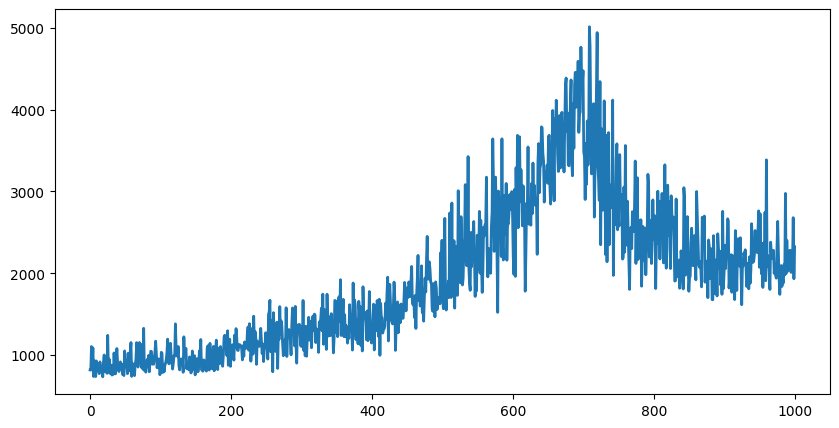

In [9]:
# plt.plot(return_history)
# plt.show()
# plt.plot(moving_average(loss_history[1000:]))
plt.plot(episode_lengths)

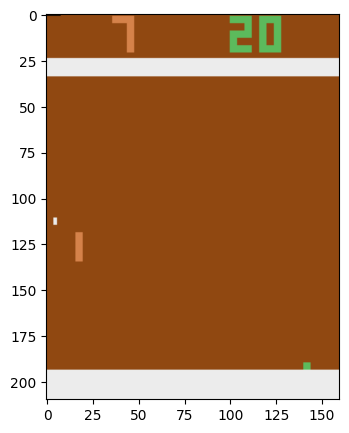

In [7]:
dqn = torch.load("/kaggle/working/Pong_best.pt")
args = Args()
env = gym.make(args.env, render_mode="rgb_array")
env = AtariPreprocessing(env, screen_size=84, grayscale_obs=True, frame_skip=1, noop_max=30)
obs, info = env.reset()
obs_stack = torch.cat(n_frames * [preprocess(obs)], 1).to(device)
truncated = terminated = False

while not terminated and not truncated:
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    dqn.eval()
    action = dqn.act(obs_stack, exploit=True)
    obs, reward, terminated, truncated, info = env.step(action)
    obs = preprocess(obs)
    obs_stack = torch.cat([obs_stack[:,1:,...], obs], 1).to(device)